In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import Image, ImageEnhance

from tensorflow.keras.utils import Sequence
import numpy as np
import pandas as pd
import os


# Suprimir todos los warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:


# Listar los dispositivos físicos disponibles, en este caso, GPUs
physical_devices = tf.config.list_physical_devices('GPU')

# Si hay alguna GPU disponible
if len(physical_devices) > 0:
    # Permitir que TensorFlow crezca dinámicamente la memoria utilizada en la GPU
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:

# Cargar el dataset

#metadata_path = '/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_16_20/dataset_16_20_emb.csv'
metadata = pd.read_csv('/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_16_20/dataset_16_20_emb.csv')  


# Ruta a las imágenes
image_path = "/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_16_20/image"


# Mostrar información básica del dataset
print (metadata.head())
print(metadata['target'].value_counts())

              image_id      sex  age_approx anatom_site_general  target
0  16_ISIC_0000001.jpg  Unknown        -1.0             Unknown       0
1  16_ISIC_0000002.jpg  Unknown        -1.0             Unknown       1
2  16_ISIC_0000004.jpg  Unknown        -1.0             Unknown       1
3  16_ISIC_0000006.jpg  Unknown        -1.0             Unknown       0
4  16_ISIC_0000007.jpg  Unknown        -1.0             Unknown       0
target
0    64985
1     7147
Name: count, dtype: int64


In [57]:
metadata = metadata [['image_id', 'target']]
metadata

,image_id,target
0,16_ISIC_0000001.jpg,0
1,16_ISIC_0000002.jpg,1
2,16_ISIC_0000004.jpg,1
3,16_ISIC_0000006.jpg,0
4,16_ISIC_0000007.jpg,0
...,...,...
72127,24_ISIC_2399304,0
72128,24_ISIC_1927506,0
72129,24_ISIC_5314244,0
72130,24_ISIC_1211710,1


In [58]:
import pandas as pd



# Función para agregar la extensión .jpg si no está presente
def add_jpg_extension(image_id):
    if not image_id.lower().endswith('.jpg'):
        return f"{image_id}.jpg"
    return image_id

# Aplicar la función a la columna 'image_id'
metadata['image_id'] = metadata['image_id'].apply(add_jpg_extension)

# Opcional: Verifica los primeros registros para asegurarte de que la operación fue correcta
print(metadata.head())

              image_id  target
0  16_ISIC_0000001.jpg       0
1  16_ISIC_0000002.jpg       1
2  16_ISIC_0000004.jpg       1
3  16_ISIC_0000006.jpg       0
4  16_ISIC_0000007.jpg       0


In [46]:
import pandas as pd

# Cargar el dataset
df = metadata

# Dividir el DataFrame en dos partes según el valor del target
df_majority = df[df['target'] == 0]
df_minority = df[df['target'] == 1]

# Reducir el número de muestras de la clase mayoritaria a 6766 para quilibrar las muestras
df_majority_downsampled = df_majority.sample(n=389, random_state=42)

# Combinar los DataFrames balanceados
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Opcional: Mezclar el DataFrame balanceado para asegurar aleatoriedad
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar la distribución de clases después del balanceo
print(df_balanced['target'].value_counts())

df_balanced.info()

target
1    389
0    389
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   isic_id  778 non-null    object
 1   target   778 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.3+ KB


In [47]:
metadata= df_balanced
metadata

,isic_id,target
0,ISIC_8460937.jpg,1
1,ISIC_7575093.jpg,1
2,ISIC_7026299.jpg,1
3,ISIC_5143941.jpg,1
4,ISIC_8137894.jpg,1
...,...,...
773,ISIC_3512146.jpg,0
774,ISIC_5565358.jpg,0
775,ISIC_0750510.jpg,0
776,ISIC_3646371.jpg,1


In [62]:
# Convertir la columna 'target' a string
metadata['target'] = metadata['target'].astype(str)

In [63]:

# Dividir los datos en entrenamiento y validación
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['target'], random_state=42)

print (train_df.shape)
print (val_df.shape)

(57705, 2)
(14427, 2)


In [60]:
# Convertir los valores de la columna target a cadenas de texto
train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)

In [64]:
# Directorio de las imágenes
#image_path = '/Users/luiseduardogarciablanco/Desktop/nueva data cancer/prueba_data_16_20/image'
'''
# Función para ajustar la nitidez
def adjust_sharpness(image):
    # Asegúrate de que la imagen esté en el rango uint8 antes de convertir
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Ajuste para imagen normalizada
    image = Image.fromarray(image)
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(2.0)  # Aumenta la nitidez
    return np.array(image) / 255.0  # Convierte de vuelta a rango [0, 1]

# Función para ajustar el contraste
def adjust_contrast(image):
    # Asegúrate de que la imagen esté en el rango uint8 antes de convertir
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Ajuste para imagen normalizada
    image = Image.fromarray(image)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Aumenta el contraste
    return np.array(image) / 255.0  # Convierte de vuelta a rango [0, 1]

# Función de preprocesamiento que combina ambas
def preprocess_function(image):
    image = adjust_sharpness(image)
    image = adjust_contrast(image)
    return image

# Crear generadores de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # División para validación
    preprocessing_function=preprocess_function  # Añade la función personalizada
)

'''
# Crear generadores de datos con augmentación
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,'''
    validation_split=0.2  # División para validación
)
#generador de entrenamiento
train_gen = train_datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=image_path,
    x_col='image_id',
    y_col='target',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)
#generador de validacion
val_gen = train_datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=image_path,
    x_col='image_id',
    y_col='target',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 57706 validated image filenames belonging to 2 classes.
Found 14426 validated image filenames belonging to 2 classes.


In [52]:
from tensorflow.keras.regularizers import l1_l2
# Cargar el modelo preentrenado ResNet50 (sin la parte superior)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas adicionales
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))
    #layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), tf.keras.metrics.AUC(name='auc')])
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), tf.keras.metrics.AUC(name='auc')])

# Entrenamiento inicial (solo las capas superiores)
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

# Descongelar algunas capas del modelo base para fine-tuning
#for layer in base_model.layers[-10:]:# probaremos a dscongelar 20, 40 y 60 capas para comprobar la eficacia del modelo
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compilar de nuevo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), tf.keras.metrics.AUC(name='auc')])

# Calcular los pesos de clase
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(metadata['target']), y=metadata['target'])
class_weights = dict(enumerate(class_weights))

# Entrenamiento con Fine-Tuning
history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    #class_weight=class_weights, # debe desactivarse si los datos están balanceados
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]#para quedarse con los mejores valores
)

# Evaluar el modelo para obtener el AUC-ROC
evaluation = model.evaluate(val_gen)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")


Epoch 1/5


2024-09-04 21:19:40.186109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.1672 - accuracy: 0.5393 - precision_4: 0.5359 - recall_4: 0.5756 - auc: 0.5580

2024-09-04 21:19:49.422371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 14s 447ms/step - loss: 1.1672 - accuracy: 0.5393 - precision_4: 0.5359 - recall_4: 0.5756 - auc: 0.5580 - val_loss: 0.7808 - val_accuracy: 0.6194 - val_precision_4: 0.6667 - val_recall_4: 0.4872 - val_auc: 0.6604
Epoch 2/5
20/20 [==============================] - 5s 231ms/step - loss: 0.7269 - accuracy: 0.6565 - precision_4: 0.6559 - recall_4: 0.6559 - auc: 0.7164 - val_loss: 0.6737 - val_accuracy: 0.7032 - val_precision_4: 0.7286 - val_recall_4: 0.6538 - val_auc: 0.7317
Epoch 3/5
20/20 [==============================] - 5s 226ms/step - loss: 0.6582 - accuracy: 0.6774 - precision_4: 0.6667 - recall_4: 0.7074 - auc: 0.7534 - val_loss: 0.6637 - val_accuracy: 0.7032 - val_precision_4: 0.7051 - val_recall_4: 0.7051 - val_auc: 0.7440
Epoch 4/5
20/20 [==============================] - 4s 221ms/step - loss: 0.5552 - accuracy: 0.7319 - precision_4: 0.7182 - recall_4: 0.7621 - auc: 0.8201 - val_loss: 0.6800 - val_accuracy: 0.7226 - val_precision_4: 0.739

Epoch 1/10


2024-09-04 21:20:11.971985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6854 - precision_5: 0.6898 - recall_5: 0.6720 - auc: 0.7572

2024-09-04 21:20:19.401400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 12s 445ms/step - loss: 0.8103 - accuracy: 0.6854 - precision_5: 0.6898 - recall_5: 0.6720 - auc: 0.7572 - val_loss: 0.7746 - val_accuracy: 0.7290 - val_precision_5: 0.8214 - val_recall_5: 0.5897 - val_auc: 0.7463
Epoch 2/10
20/20 [==============================] - 5s 256ms/step - loss: 0.5196 - accuracy: 0.7769 - precision_5: 0.7622 - recall_5: 0.8039 - auc: 0.8719 - val_loss: 0.8736 - val_accuracy: 0.7226 - val_precision_5: 0.9070 - val_recall_5: 0.5000 - val_auc: 0.7630
Epoch 3/10
20/20 [==============================] - 5s 252ms/step - loss: 0.4969 - accuracy: 0.7913 - precision_5: 0.7910 - recall_5: 0.7910 - auc: 0.8758 - val_loss: 0.8884 - val_accuracy: 0.7032 - val_precision_5: 0.8810 - val_recall_5: 0.4744 - val_auc: 0.7543
Epoch 4/10
5/5 [==============================] - 1s 166ms/step - loss: 0.7746 - accuracy: 0.7290 - precision_5: 0.8214 - recall_5: 0.5897 - auc: 0.7463
Test Loss: 0.774600088596344
Test Accuracy: 0.7290322780609131
Te

In [53]:
# Evaluar el modelo
loss, accuracy, precision, recall, auc= model.evaluate(val_gen)

5/5 [==============================] - 1s 175ms/step - loss: 0.7746 - accuracy: 0.7290 - precision_5: 0.8214 - recall_5: 0.5897 - auc: 0.7463


In [54]:
# Predecir las probabilidades
y_pred_probs = model.predict(val_gen)

# Ajustar el umbral de decisión
threshold = 0.5 # Ajustar según sea necesario
y_pred_adjusted = (y_pred_probs > threshold).astype(int)

# Calcular y mostrar métricas
from sklearn.metrics import classification_report

y_true = val_gen.classes
print(classification_report(y_true, y_pred_adjusted, target_names=['Class 0', 'Class 1']))

2024-09-04 21:21:05.474771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 245ms/step
              precision    recall  f1-score   support

     Class 0       0.68      0.87      0.76        77
     Class 1       0.82      0.59      0.69        78

    accuracy                           0.73       155
   macro avg       0.75      0.73      0.72       155
weighted avg       0.75      0.73      0.72       155



descongelando 10 capas conseguimos el siguiente resultado:

85/85 [==============================] - 19s 214ms/step
              precision    recall  f1-score   support

     Class 0       0.84      0.79      0.82      1373
     Class 1       0.80      0.85      0.82      1333

    accuracy                           0.82      2706
   macro avg       0.82      0.82      0.82      2706
weighted avg       0.82      0.82      0.82      2706



descongelando 20 capas conseguimos el sigiuente resultado:

85/85 [==============================] - 16s 177ms/step
              precision    recall  f1-score   support

     Class 0       0.84      0.82      0.83      1373
     Class 1       0.82      0.84      0.83      1333

    accuracy                           0.83      2706
   macro avg       0.83      0.83      0.83      2706
weighted avg       0.83      0.83      0.83      2706



descongelando 40 dio este resultado:
85/85 [==============================] - 16s 179ms/step
              precision    recall  f1-score   support

     Class 0       0.87      0.82      0.85      1373
     Class 1       0.82      0.88      0.85      1333

    accuracy                           0.85      2706
   macro avg       0.85      0.85      0.85      2706
weighted avg       0.85      0.85      0.85      2706



descongelando 60 dio este resultado:
85/85 [==============================] - 15s 167ms/step
              precision    recall  f1-score   support

     Class 0       0.85      0.83      0.84      1373
     Class 1       0.83      0.85      0.84      1333

    accuracy                           0.84      2706
   macro avg       0.84      0.84      0.84      2706
weighted avg       0.84      0.84      0.84      2706



In [55]:
# Guardar el modelo entrenado
model.save('resnet50_fine_tuned_model_20.h5')

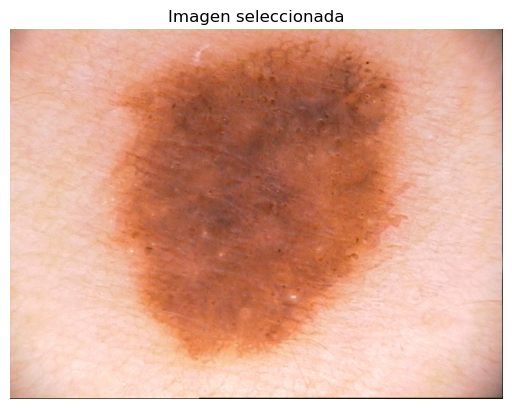

2024-09-01 12:01:50.720433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 701ms/step
Predicción: 1 - positivo melanoma


In [11]:
# generamos esta instancia para subir una foto "propia" desd el ordenador para validar el modelo de prediccion con una foto fuera del conjunto "test"
import numpy as np
from PIL import Image
from tkinter import Tk, filedialog
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Función para cargar y preprocesar una imagen
def preprocess_image(image_path, size=(256, 256)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para el batch
        return img_array

# Función para seleccionar una imagen desde el ordenador (abre una ventana del explorador de archivos donde debes seleccionar una imagen)
def select_image():
    root = Tk()
    root.withdraw()  # Cerrar la ventana principal de Tkinter
    file_path = filedialog.askopenfilename()
    return file_path

# Función para predecir la clase de una imagen
def predict_image(model, image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    predicted_class = '1 - positivo melanoma' if np.argmax(prediction[0]) == 0 else '0 - negativo melanoma'
    return predicted_class

# Cargar el modelo guardado
best_model = load_model('/Users/luiseduardogarciablanco/Desktop/bootcamp/Proyecto_Final_Cancer/src/prueba_16_20/resnet50_fine_tuned_model_40.h5')

# Seleccionar una imagen desde el ordenador
image_path = select_image()

# Mostrar la imagen seleccionada
plt.imshow(Image.open(image_path))
plt.title("Imagen seleccionada")
plt.axis('off')
plt.show()

# Realizar la predicción
predicted_class = predict_image(best_model, image_path)
print(f'Predicción: {predicted_class}')

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input


# Función para cargar y preprocesar una imagen
def preprocess_image(image_path, size=(256, 256)):
    with Image.open(image_path) as img:
        img = img.resize(size)
        img_array = np.array(img)
        img_array = preprocess_input(img_array)  # Normalización específica de ResNet50
        img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para el batch
        return img_array

# Función para seleccionar una imagen desde el ordenador
def select_image():
    root = Tk()
    root.withdraw()  # Cerrar la ventana principal de Tkinter
    file_path = filedialog.askopenfilename()
    return file_path

# Función para predecir la clase de una imagen
def predict_image(model, image_path):
    image = preprocess_image(image_path)
    predictions = model.predict(image)
    prediction = predictions[0][0]  # Suponiendo que el modelo devuelve un array con una sola probabilidad

    # Debugging: imprime el valor de la predicción
    print(f"Predicción cruda: {prediction}")

    # Interpretar el resultado basado en un umbral
    if prediction < 0.5:
        result_message = "El modelo no detecta una alta probabilidad de melanoma maligno."
    else:
        result_message = "El modelo ha detectado una alta probabilidad de melanoma maligno."
    
    return result_message

# Cargar el modelo guardado (asegúrate de que esta ruta sea correcta)
best_model = load_model('/Users/luiseduardogarciablanco/Desktop/bootcamp/Proyecto_Final_Cancer/src/prueba_16_20/resnet50_fine_tuned_model_20.h5')

# Seleccionar una imagen desde el ordenador
image_path = select_image()

# Mostrar la imagen seleccionada
plt.imshow(Image.open(image_path))
plt.title("Imagen seleccionada")
plt.axis('off')
plt.show()

# Realizar la predicción
result_message = predict_image(best_model, image_path)
print(f'Resultado de la predicción: {result_message}')

IsADirectoryError: [Errno 21] Is a directory: '/Users/luiseduardogarciablanco/Desktop/bootcamp/Proyecto_Final_Cancer/src/prueba_16_20'